In [29]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
'''
 @File  : lab9.py
 @Author: Yangjie
 @license : Copyright(C), SUSTech,Shenzhen,China
 @Contact : yangj3@mail.sustc.edu.cn
 @Date  : 2018/11/20
 @IDE : PyCharm
 @Desc  : this code is lab9 in image and video process. it has different ops to detect edge, and canny, log ,global threshold
 '''
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from skimage import measure
from copy import deepcopy as dcp


class IMG:
    def __init__(self, name, mark=None):
        self.path = 'D:\graduated\Image_process\lab\PGM_images\\'
        self.savepath = 'D:\graduated\Image_process\lab\lab_report\lab10\imagesave\\'
        self.name = name
        self.prop = '.pgm'
        self.mark = mark
        # self.img=None
        if os.path.exists(self.savepath):
            pass   
        else:
            os.mkdir(self.savepath)
        

    def load(self):
        self.imapath = self.path + self.name + self.prop
        self.img = np.float64(cv2.imread(self.imapath, 0))
        self.save(self.img, 'original')
        return self.img

    def save(self, img, mark=None, flag=0):
        if flag:
            img = cv2.equalizeHist(np.uint8(img))
        self.mark = mark
        savepath = self.savepath + self.name + '_' + self.mark + '.jpg'
        cv2.imwrite(savepath, img)
        return img
    
    def disp(self,winName,img,sizeflag=cv2.WINDOW_NORMAL):
        img=cv2.equalizeHist(np.uint8(img))
        if sizeflag==1:
            sizeflag=cv2.WINDOW_AUTOSIZE
        cv2.namedWindow(winName,sizeflag)
        cv2.imshow(winName,img) 
        cv2.waitKey(0)
        cv2.destroyWindow(winName)
        return img
    
    def psave(self,img,mark=None,cb=0): # shown image in windows and save
        fig = plt.gcf() 
        plt.imshow(img,cmap='gray')
        if cb:
            plt.colorbar()
        plt.xticks([]), plt.yticks([])
        savepath=self.savepath+self.name+'_'+mark+'.jpg'
        fig.savefig(savepath,dpi=500,bbox_inches='tight')
        plt.close()
        
    def fsave(self,fig,mark=None): # save plot fihiure
        #plt.xticks([]), plt.yticks([])
        savepath=self.savepath+self.name+'_'+mark+'.jpg'
        fig.savefig(savepath,dpi=500,bbox_inches='tight')
        plt.close()
    
    def histsave(self, img,Mark):
        fig = plt.gcf() 
        plt.hist(img.ravel(),256);
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        self.fsave(fig,mark=Mark+'_hist')


class SEG:
    def __init__(self):
        self.name = 'Segmentation'

    def EdgeDtect(self, img, opname, part=None):
        Roberts_x = np.array([-1, 0, 0, 1])
        Roberts_y = np.array([0, -1, 1, 0])
        Prewitt_x = np.array([-1, -1, -1, 0, 0, 0, 1, 1, 1])
        Sobel_x = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1])

        Roberts_x = Roberts_x.reshape(2, 2)
        Roberts_y = Roberts_y.reshape(2, 2)
        Roberts = [Roberts_x, Roberts_y]

        Prewitt_x = Prewitt_x.reshape(3, 3)
        Prewitt_y = Prewitt_x.T
        Prewitt = [Prewitt_x, Prewitt_y]

        Sobel_x = Sobel_x.reshape(3, 3)
        Sobel_y = Sobel_x.T
        Sobel = [Sobel_x, Sobel_y]

        op_lib = {'Roberts': Roberts, 'Prewitt': Prewitt, 'Sobel': Sobel}
        op_set = op_lib[opname]
        edge = np.zeros((img.shape[0] - op_set[0].shape[0] + 1, img.shape[1] - op_set[0].shape[1] + 1))
        if part is None:
            for k, op in enumerate(op_set):
                temp = np.zeros((img.shape[0] - op.shape[0] + 1, img.shape[1] - op.shape[1] + 1))
                for x in range(img.shape[0] - op.shape[0] + 1):
                    for y in range(img.shape[1] - op.shape[1] + 1):
                        ROI = img[x:x + op.shape[0], y:y + op.shape[1]]
                        temp[x, y] = np.sum(ROI * op)
                edge += temp ** 2

            edge = np.power(edge, 1 / (k + 1))
            return (edge)

        else:
            op = op_set[part]
            for x in range(img.shape[0] - op.shape[0] + 1):
                for y in range(img.shape[1] - op.shape[1] + 1):
                    ROI = img[x:x + op.shape[0], y:y + op.shape[1]]
                    edge[x, y] = np.sum(ROI * op)
            return (edge)


    def Threshold(self, edge, thrshold, percent=1):
        if percent:  # thrshold is percentage
            thrshold = np.max(edge) * thrshold
        aim = edge > thrshold
        edge[aim] = 255
        edge[~aim] = 0
        return (edge)

    def  OTSU(self, img):
        hist = cv2.calcHist([img],[0],None,[256],[0,256]).reshape(-1,)
        TotalNum=sum(hist)
        TotalSum=np.sum(hist*range(256))
        BackCount=0
        SumBack=0
        SumFront=0
        Maxsigma=0
        for k in range(256):
            Num=hist[k]
            BackCount += Num
            FrontCount=TotalNum-BackCount
            if (FrontCount ==0):
                break
            elif (BackCount* Num ==0):
                continue
            SumBack += k* Num
            MeanBack = SumBack/BackCount
            MeanFront = (TotalSum-SumBack)/FrontCount
            sigma=BackCount*FrontCount*(MeanBack-MeanFront )**2
            if (sigma >= Maxsigma):
                Threshold = k
                Maxsigma = sigma
        ret,thimage=cv2.threshold(img,Threshold,255,cv2.THRESH_BINARY)    
        return (Threshold, thimage)
    
    def Partition(self, img,row,col,I):
        row_index=np.linspace(0,img.shape[0],row+1)
        col_index=np.linspace(0,img.shape[1],col+1)
        Thrimg=np.zeros(img.shape)
        for rowCount in range(row):
            for colCount in range(col):
                lx=int(row_index[rowCount ])
                rx=int(row_index[rowCount +1])
                ly=int(col_index[colCount ])
                ry=int(col_index[colCount +1])
                part=img[lx:rx,ly:ry]
                threshold, Thrpart=S.OTSU(part)
                Thrimg[lx:rx,ly:ry]=Thrpart
                I.histsave(part,Mark='sub_'+str(rowCount)+'_'+str(colCount)+'_Threshold_'+str(threshold))

        for rowline in row_index[1:-1]:
            img[int(rowline)]=255
        for colline in col_index[1:-1]:
            img[:,int(colline)]=255
        return (Thrimg, img)
    
    def moving_average_thresholding (self,img,n=20,b=0.5):
        ima=img[:]
        for k, row in enumerate(ima):
            if k%2:
                ima[k,:]=row[::-1]
        ima=ima.reshape(-1,)
        m=0
        Threshold=[]
        pada=np.hstack((np.zeros(n),ima))
        for k,p in enumerate(ima):
            m += b*(pada[k+n]-pada[k])/n
            Threshold.append(m)
        ima[ima<Threshold]=0
        ima[~(ima<Threshold)]=255
        ima=ima.reshape(img.shape)

        for k, row in enumerate(ima):
            if k%2:
                ima[k,:]=row[::-1]
        return (ima)
    
    def EroTonePiont(self, img):
        kernel = np.ones((3,3),np.uint8)
        onePointImg=np.zeros(img.shape)
        X=[]
        Y=[]
        label_image,num = measure.label(img, return_num=True)
        for k in range(1,num+1):
            connet=np.zeros(img.shape)
            x,y= np.where(label_image==k)
            r=int(np.floor(len(x)/2))
            X.append(x[r])
            Y.append(y[r])
        for x,y in zip(X,Y):
            onePointImg [x,y]=255
        dilation = cv2.dilate(onePointImg,kernel,iterations = 1)
        return(np.uint8(onePointImg),dilation)
    
    def doubleThr(self,img,T1,T2):
        src=np.zeros(img.shape)
        src[img>=T1]=100
        src[img>=T2]=255
        return(src)
    
    def connect_detec_point(self, A, EM, x, y,visual=0):
        Xk_1 = A * 0
        Xk = dcp(Xk_1)
        Xk[x, y] = 255;
        if visual:
            winName = 'find connect'
            cv2.namedWindow(winName, cv2.WINDOW_NORMAL)
        while (Xk != Xk_1).any():
            if visual:
                cv2.imshow(winName, Xk)
                cv2.waitKey(10)
            # |cv2.destroyWindow(winName)
            Xk_1 = Xk
            #temp = self.dilation(Xk_1, EM)
            temp = cv2.dilate(Xk_1,EM,iterations = 1)
            Xk = cv2.bitwise_and(dcp(temp), dcp(A))
        if visual:
            cv2.waitKey(100)
            cv2.destroyWindow(winName)
        return  Xk
    
    
    def connect_detec(self, A, EM, Seed,visual=0):
        Connect_set = A * 0
        result = A * 0
        if visual:
            winName1 = 'Seed'
            cv2.namedWindow(winName1, cv2.WINDOW_NORMAL)
        while Seed.any():
           
            X, Y = np.where(Seed == 255)
            Conect = self.connect_detec_point(A, EM, X[0], Y[0],visual)
            result += Conect 
            if visual:
                cv2.imshow(winName1, result)
            Conect_inv = cv2.bitwise_not(Conect)
            Seed = cv2.bitwise_and(Seed, Conect_inv)
        
        if visual:
            cv2.waitKey(3000)
            cv2.destroyWindow(winName1)
        return result



In [84]:
if  __name__ == '__main__':
    p1=0
    p2=0
    p3=0
    p4=1


    if p1 :
        print('\n---Problem 1----\n')
        imname = 'large_septagon_gaussian_noise_mean_0_std_50_added'
        Op_name = ['original', 'smoothed']
        I = IMG(imname)
        oimg =np.uint8( I.load())
        blur = cv2.blur(oimg,(5,5))
        I.save(blur,mark='smoothed')
        imgset=[oimg,blur]
        S = SEG()
        for k,method in enumerate(Op_name):
            print(method + '....')
            img=imgset[k]
            I.histsave(img,method)
            Threshold, thimage=S.OTSU(img)
            I.save(thimage, mark=method+'_'+str(int(Threshold)))
            ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            I.save(th2, mark=method+'_opencv_'+str(int(ret2)))
            
        print('\n==== Problem 1 done ====\n')

    if p2:
        print('\n---Problem 2----\n')
        imnameset = ['septagon_noisy_shaded']
        methodset = ['Partition', 'Otsu']
        S = SEG()
        for k,imname in enumerate(imnameset):
            print(imname + '....')
            I = IMG(imname)
            img = np.uint8( I.load())
            I.histsave(img,'' )
            for method in methodset:
                print('\t' + method)
                if method == 'Partition':
                    Thrimg,lineimg=S.Partition( img,2,3,I)
                    I.save(Thrimg,mark=method)
                    I.save(lineimg, mark=method+'_line')
                elif method == 'Otsu':
                    Threshold, thimage=S.OTSU(img)
                    I.save(thimage, mark=method+'_'+str(int(Threshold)))
        print('\n==== Problem 2 done ====\n')


    if p3 :
        ## -------------- P3----------------
        print('\n---Problem 3----\n')
        imnameset = ['spot_shaded_text_image']
        methodset = ['moving_average_thresholding']
        S = SEG()
        for k,imname in enumerate(imnameset):
            print(imname + '....')
            I = IMG(imname)
            img = I.load()
            for method in methodset:
                print('\t' + method)
                thimage=S.moving_average_thresholding (img)
                I.save(thimage, mark=method)
                
                
        print('\n==== Problem 3 done ====\n')

        
    if p4 :
        ## -------------- P3----------------
        print('\n---Problem 4----\n')
        imnameset = ['defective_weld','noisy_region']#
        methodset = ['region_growing']
        S=SEG()
        for k,imname in enumerate(imnameset):
            print(imname + '....')
            I = IMG(imname)
            img = np.uint8(I.load())
            for method in methodset:
                print('\t' + method)
                I.histsave(img,Mark='orignal')
                if imname=='defective_weld':
                    ret2,thimg = cv2.threshold(img,254,255,cv2.THRESH_BINARY)
                    I.save(thimg,mark='Thr_254')
                    seed,dilation=S.EroTonePiont(thimg)
                    I.save(dilation,mark='oneP')
                    diff_img=abs(thimg-img)
                    I.save(diff_img,mark='dif_abs')
                    I.histsave(diff_img,Mark='dif_abs')
                    double_img=S.doubleThr(diff_img,68,126)
                    I.save(double_img,mark='double_thr')
                    ret2,thimg2 = cv2.threshold(double_img,68,255,cv2.THRESH_BINARY)
                    I.save(thimg2,mark='diff_thr')
                    Q=cv2.bitwise_not(np.uint8(thimg2))
                    
                else:
                    SEED=np.zeros(img.shape)
                    SEED[abs(img-127)>10]=255
                    seed,dilation=S.EroTonePiont(SEED)
                    blur = cv2.blur(img,(5,5))
                    I.save(blur,mark='blur')
                    Q=np.zeros(img.shape,dtype=np.uint8)
                    Q[abs(blur-127)>1]=255
                    
                kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                result=S.connect_detec(Q, kernel, seed,visual=0)
                I.save(result,mark='final')      
        print('\n==== Problem 4 done ====\n')








---Problem 4----

defective_weld....
	region_growing
noisy_region....
	region_growing

==== Problem 4 done ====



In [80]:
Q=np.zeros(img.shape,dtype=np.uint8)
Q

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [62]:
SEED=np.zeros(img.shape,dtype=np.uint8)
SEED

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

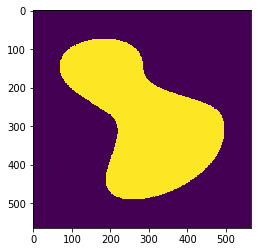

In [71]:


plt.imshow(Q)

In [6]:
A=Q
Seed=seed
EM=kernel

Connect_set = A * 0
result = A * 0
X, Y = np.where(Seed == 255)
Conect = S.connect_detec_point(A, EM, X[0], Y[0])
result += Conect 







In [11]:
Conect_inv = cv2.bitwise_not(Conect)
Seed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x=X[0]
y=Y[0]
Xk_1 = A * 0
Xk = dcp(Xk_1)
Xk[x, y] = 255
Xk_1 = Xk
temp = cv2.dilate(Xk_1,EM,iterations = 1)
Xk = cv2.bitwise_and(dcp(temp), dcp(A))

In [425]:
Connect_set = A * 0
result = A * 0
if visual:
    winName1 = 'Seed'
    cv2.namedWindow(winName1, cv2.WINDOW_NORMAL)
while Seed.any():

    X, Y = np.where(Seed == 255)
    Conect = self.connect_detec_point(A, EM, X[0], Y[0])
    result += Conect 
    if visual:
        cv2.imshow(winName1, result)
    Conect_inv = cv2.bitwise_not(Conect)
    Seed = cv2.bitwise_and(Seed, Conect_inv)
print('Catch %d connected component' % len(result))
if visual:
    cv2.waitKey(1)
    cv2.destroyWindow(winName1)


    
        
    
    

254

In [ ]:
Xk_1 = Xk
temp = cv2.dilate(Xk_1,EM,iterations = 1)
Xk = cv2.bitwise_and(dcp(temp), dcp(A))


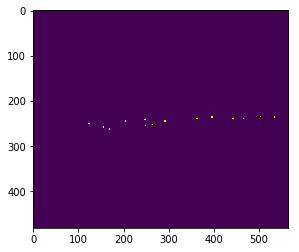

In [400]:
Xk_1 = A * 0
Xk = dcp(Xk_1)
Xk[x, y] = 255;
if visual:
    winName = 'find connect'
    cv2.namedWindow(winName, cv2.WINDOW_NORMAL)
while (Xk != Xk_1).any():
    if visual:
        cv2.imshow(winName, Xk)
        cv2.waitKey(1)
    # |cv2.destroyWindow(winName)
    Xk_1 = Xk
    #temp = self.dilation(Xk_1, EM)
    temp = cv2.dilate(Xk_1,EM,iterations = 1)
    Xk = cv2.bitwise_and(dcp(temp), dcp(A))
if visual:
    cv2.waitKey(1)
    cv2.destroyWindow(winName)
    

In [389]:
x,y= np.where(label_image==3)
x.sort()
y.sort()
r=area

array([500, 500, 499, 500, 501, 502, 503, 504, 505, 506], dtype=int64)

In [395]:
[].append(x[1])


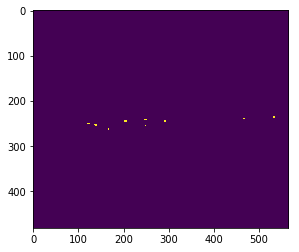

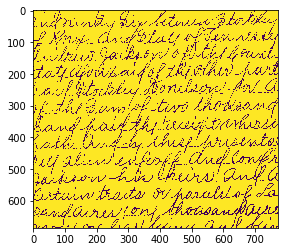

In [259]:
plt.imshow(ima)

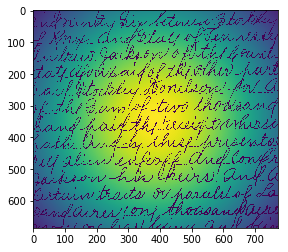

In [256]:
plt.imshow(img)


In [166]:
a

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  6.,  5.,  4.,
        7.,  8.,  9., 11., 10.,  9.])

In [24]:
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2

118.0

In [31]:
Threshold

118

In [32]:
ret2

118.0

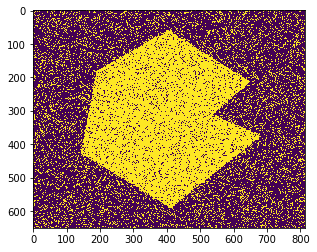

In [27]:
ret,th1=cv2.threshold(img,118,255,cv2.THRESH_BINARY)
plt.imshow(th1)

In [30]:
th1

array([[  0, 255,   0, ..., 255,   0, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ..., 255,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8)

In [65]:
help(cv2.threshold)

Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a